In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip '/content/gdrive/My Drive/Colab Notebooks/CS229 Project/PlantVillage_cyclegan.zip'

In [ ]:
import time
import copy

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from sklearn import metrics
import os

# Load PlantVillage Dataset

In [ ]:
#Organizing the dataset
batch_size = 32

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [ ]:
def balanced_sampler_weights(images, nclasses):
  count = [0] * nclasses
  for img in images:
    count[img[1]] += 1
  total_num_imgs = float(sum(count))

  weight_per_class = [total_num_imgs/float(count[i]) for i in range(nclasses)]
  weight_per_img = [weight_per_class[img[1]] for _, img in enumerate(images)]
  return weight_per_img

In [ ]:
# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        # transforms.RandomAffine(0,shear=30),
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'PlantVillage_cyclegan'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

balance_classes = False

if balance_classes:
  train_weights = balanced_sampler_weights(image_datasets['train'].imgs, len(image_datasets['train'].classes))
  train_weights = torch.DoubleTensor(train_weights)
  train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_weights, len(train_weights))
  samplers = {'train': train_sampler, 'val': None}

  # Using the image datasets and the trainforms, define the dataloaders
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, sampler=samplers[x], num_workers=4) for x in ['train', 'val']}
else:
  print("No balancing")
  # Using the image datasets and the trainforms, define the dataloaders
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

x,y = next(iter(dataloaders['train']))
print(x.shape, y.shape)

No balancing
torch.Size([32, 3, 224, 224]) torch.Size([32])


In [ ]:
tmp = dataloaders['train']

In [ ]:
num_images_show = 10
i = 0
for x in tmp:
  print(np.transpose(x[0][0], (1,2,0)).shape)
  tmp_img = np.transpose(x[0][0].numpy(), (1,2,0))
  print(tmp_img.shape)
  plt.imshow(tmp_img)
  plt.show()
  i+=1
  if i >= num_images_show:
    break

In [ ]:
buckets_split = {}
for split in ['train', 'val']:
  classes = image_datasets[split].classes
  buckets_split[split] = {x: 0 for x in classes}

for split in ['train', 'val']:
  ds = dataloaders[split]
  for data, batch_target in ds:
    for target in batch_target:
      class_idx = target.item()
      buckets_split[split][classes[class_idx]] += 1

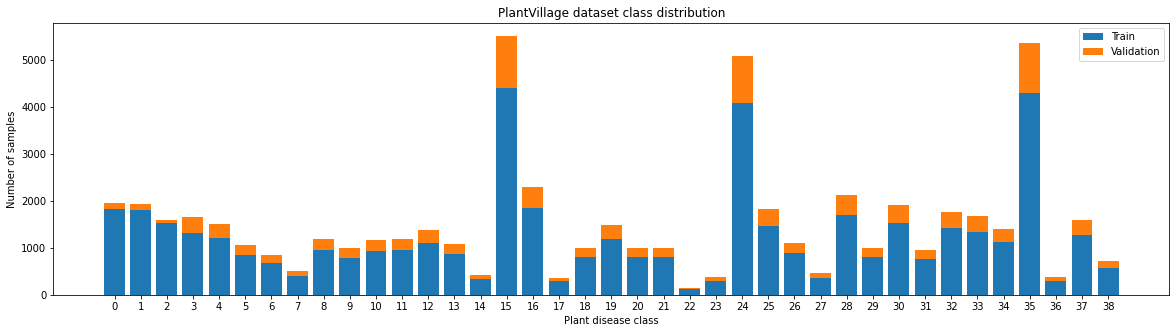

In [ ]:
plt.figure(figsize=(20,5))
ind = range(len(buckets_split['train'].keys()))
p1 = plt.bar(ind,list(buckets_split['train'].values()))
p2 = plt.bar(ind,list(buckets_split['val'].values()), bottom=list(buckets_split['train'].values()))
plt.title("PlantVillage dataset class distribution")
plt.ylabel('Number of samples')
plt.xlabel('Plant disease class')
plt.xticks(ind)
plt.legend((p1[0], p2[0]), ('Train', 'Validation'))
plt.show()

# Build and train classifier

In [ ]:
model = models.resnet152(pretrained=True)

# for param in model.parameters():
#   param.requires_grad = False
# model = models.resnet50(pretrained=True)

In [ ]:
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 512)),
                                        ('relu', nn.ReLU()),
                                        ('fc2', nn.Linear(512, 39)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.fc = classifier

In [ ]:
#Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        scheduler.step()
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Train and update weights
        for inputs, labels in dataloaders['train']:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()

          # Forward
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs,1)

          # Backward + optimize
          loss.backward()
          optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']

        print(f"Train Loss: {epoch_loss} Acc: {epoch_acc}")

        # Evaluate on validation set
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes['val']
        epoch_acc = running_corrects.double() / dataset_sizes['val']

        print(f"Validation Loss: {epoch_loss} Acc: {epoch_acc}")

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        if epoch % 5 == 0:
            # Save model every 5 epochs
            model.epochs = epoch
            checkpoint = {'input_size': [3, 224, 224],
                  'batch_size': dataloaders['train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'epoch': model.epochs}
            torch.save(checkpoint, f"cyclegan_augmentation_{epoch}_epochs_checkpoint.pth")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## With CycleGAN augmentation

In [ ]:
# Train a model with a pre-trained network
num_epochs = 20
if train_on_gpu:
    print ("Using GPU: "+ str(train_on_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

Using GPU: True
Epoch 1/20
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Loss: 0.7421623301331071 Acc: 0.7853598532232507
Validation Loss: 0.2918343214999975 Acc: 0.9040348964013085
Epoch 2/20
----------
Train Loss: 0.43770354792081767 Acc: 0.8631265115503295
Validation Loss: 0.21949705248072293 Acc: 0.9282079243911304
Epoch 3/20
----------
Train Loss: 0.39601183799431366 Acc: 0.8755733466766742
Validation Loss: 0.19481605152429904 Acc: 0.9374772809887313
Epoch 4/20
----------
Train Loss: 0.3591879079741738 Acc: 0.885080477024435
Validation Loss: 0.2169022157338696 Acc: 0.9267539076699381
Epoch 5/20
----------
Train Loss: 0.2527582844682476 Acc: 0.9192519389542156
Validation Loss: 0.1520214088136545 Acc: 0.9499272991639404
Epoch 6/20
----------
Train Loss: 0.2406004540328337 Acc: 0.9220040030022517
Validation Loss: 0.14055541319341303 Acc: 0.9521083242457288
Epoch 7/20
----------
Train Loss: 0.23316451838312569 Acc: 0.924547577349679
Validation Loss: 0.1256903345973892 Acc: 0.9583787713558706
Epoch 8/20
----------
Train Loss: 0.2305439740541172 Acc: 0

In [ ]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  label_accuracy = {x: 0 for x in image_datasets['val'].classes}
  predicted_labels = []
  true_labels = []

  for images, labels in dataloaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    acc = equality.type_as(torch.FloatTensor())
    accuracy += acc.mean()
    for i,x in enumerate(labels.data):
      label_accuracy[image_datasets['val'].classes[x]] += acc[i]
      predicted_labels.append(ps.max(1)[1][i])
      true_labels.append(x)

  print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))

  return true_labels, predicted_labels

In [ ]:
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'epoch': model.epochs}
torch.save(checkpoint, '/content/gdrive/My Drive/Colab Notebooks/CS229 Project/cyclegan_augmentation_checkpoint.pth')

In [ ]:
true_labels, predicted_labels = test(model, dataloaders, device)

Testing Accuracy: 0.961


In [ ]:
predicted_labels_list = [x.cpu().item() for x in predicted_labels]
true_labels_list = [x.cpu().item() for x in true_labels]

In [ ]:
# Print the confusion matrix
print(metrics.confusion_matrix(true_labels_list, predicted_labels_list))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_labels_list, predicted_labels_list, target_names=image_datasets['val'].classes, digits=3))

[[112   0   0 ...   0   0   0]
 [  0 114   0 ...   0   0   0]
 [  2   0  48 ...   0   0   0]
 ...
 [  0   0   0 ...  71   0   0]
 [  0   0   0 ...   0 316   0]
 [  0   0   0 ...   0   0 143]]
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      0.957     0.889     0.922       126
                                 Apple___Black_rot      1.000     0.912     0.954       125
                          Apple___Cedar_apple_rust      1.000     0.873     0.932        55
                                   Apple___healthy      0.942     0.985     0.963       329
                               Blueberry___healthy      0.993     0.983     0.988       300
          Cherry_(including_sour)___Powdery_mildew      0.995     0.981     0.988       210
                 Cherry_(including_sour)___healthy      0.983     0.994     0.988       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.876     0.757

##With NST augmentation

In [ ]:
# Train a model with a pre-trained network
num_epochs = 20
if train_on_gpu:
    print ("Using GPU: "+ str(train_on_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

Using GPU: True
Epoch 1/20
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Loss: 0.7132646511875717 Acc: 0.7922616494045066
Validation Loss: 0.3029611777529115 Acc: 0.9009451108687749
Epoch 2/20
----------
Train Loss: 0.43201593625876944 Acc: 0.8642111499254357
Validation Loss: 0.24482278910410357 Acc: 0.9202108324245728
Epoch 3/20
----------
Train Loss: 0.38436006722841165 Acc: 0.8807991665134522
Validation Loss: 0.2143479934749669 Acc: 0.930570701563068
Epoch 4/20
----------
Train Loss: 0.3622512972452178 Acc: 0.8850891708034566
Validation Loss: 0.1840301133456641 Acc: 0.9372955288985823
Epoch 5/20
----------
Train Loss: 0.24494917121538162 Acc: 0.9218197789626361
Validation Loss: 0.12895978800884728 Acc: 0.9583787713558706
Epoch 6/20
----------
Train Loss: 0.235131638993713 Acc: 0.9245163530877817
Validation Loss: 0.13768234966787934 Acc: 0.9529262086513994
Epoch 7/20
----------
Train Loss: 0.22344685056105285 Acc: 0.9278257849686422
Validation Loss: 0.12437672283272257 Acc: 0.9588331515812432
Epoch 8/20
----------
Train Loss: 0.2229138416125897 Acc:

In [ ]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  label_accuracy = {x: 0 for x in image_datasets['val'].classes}
  predicted_labels = []
  true_labels = []

  for images, labels in dataloaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    acc = equality.type_as(torch.FloatTensor())
    accuracy += acc.mean()
    for i,x in enumerate(labels.data):
      label_accuracy[image_datasets['val'].classes[x]] += acc[i]
      predicted_labels.append(ps.max(1)[1][i])
      true_labels.append(x)

  print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))

  return true_labels, predicted_labels

In [ ]:
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'epoch': model.epochs}
torch.save(checkpoint, 'nst_augmentation_checkpoint.pth')

In [ ]:
true_labels, predicted_labels = test(model, dataloaders, device)

Testing Accuracy: 0.963


In [ ]:
predicted_labels_list = [x.cpu().item() for x in predicted_labels]
true_labels_list = [x.cpu().item() for x in true_labels]

In [ ]:
# Print the confusion matrix
print(metrics.confusion_matrix(true_labels_list, predicted_labels_list))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_labels_list, predicted_labels_list, target_names=image_datasets['val'].classes, digits=3))

[[112   0   2 ...   0   0   0]
 [  0 124   0 ...   0   0   0]
 [  2   0  52 ...   0   0   0]
 ...
 [  0   0   0 ...  72   0   0]
 [  0   0   0 ...   0 318   0]
 [  0   0   0 ...   0   0 143]]
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      0.941     0.889     0.914       126
                                 Apple___Black_rot      0.984     0.992     0.988       125
                          Apple___Cedar_apple_rust      0.963     0.945     0.954        55
                                   Apple___healthy      0.953     0.976     0.964       329
                               Blueberry___healthy      0.990     0.980     0.985       300
          Cherry_(including_sour)___Powdery_mildew      0.995     0.990     0.993       210
                 Cherry_(including_sour)___healthy      0.994     0.994     0.994       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.842     0.825

##No augmentation

In [ ]:
# Train a model with a pre-trained network
num_epochs = 10
if train_on_gpu:
    print ("Using GPU: "+ str(train_on_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Using GPU: True
Epoch 1/10
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Loss: 0.7443560107551198 Acc: 0.7814885496183206
Validation Loss: 0.37060417795519274 Acc: 0.8800436205016358
Epoch 2/10
----------
Train Loss: 0.4475296107217296 Acc: 0.8578925845147218
Validation Loss: 0.38579534247696334 Acc: 0.8790439840058161
Epoch 3/10
----------
Train Loss: 0.40331033510550374 Acc: 0.8738413304252999
Validation Loss: 0.22810047492249494 Acc: 0.923209741912032
Epoch 4/10
----------
Train Loss: 0.3788337055140086 Acc: 0.880452562704471
Validation Loss: 0.15990519331871747 Acc: 0.947928026172301
Epoch 5/10
----------
Train Loss: 0.2554146497669826 Acc: 0.9174845510723373
Validation Loss: 0.13524317090450005 Acc: 0.9550163576881133
Epoch 6/10
----------
Train Loss: 0.24336389446802376 Acc: 0.9202335514358415
Validation Loss: 0.11559840762444039 Acc: 0.9614685568884042
Epoch 7/10
----------
Train Loss: 0.24257489814826225 Acc: 0.9222328244274809
Validation Loss: 0.125905901212577 Acc: 0.9576517629952744
Epoch 8/10
----------
Train Loss: 0.23097239990736607 Acc:

In [ ]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  label_accuracy = {x: 0 for x in splits['val'].dataset.classes}
  predicted_labels = []
  true_labels = []

  for images, labels in dataloaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    acc = equality.type_as(torch.FloatTensor())
    accuracy += acc.mean()
    for i,x in enumerate(labels.data):
      label_accuracy[splits['val'].dataset.classes[x]] += acc[i]
      predicted_labels.append(ps.max(1)[1][i])
      true_labels.append(x)

  print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))
  for x in splits['val'].dataset.classes:
    acc = label_accuracy[x]/buckets_split['val'][x]
    print(f"Testing Accuracy on label {x} with {buckets_split['train'][x]} training examples: {acc}")

  return true_labels, predicted_labels

In [ ]:
true_labels, predicted_labels = test(model, dataloaders, device)

Testing Accuracy: 0.976
Testing Accuracy on label Apple___Apple_scab with 456 training examples: 0.954023003578186
Testing Accuracy on label Apple___Black_rot with 462 training examples: 0.9937106966972351
Testing Accuracy on label Apple___Cedar_apple_rust with 212 training examples: 0.9841269850730896
Testing Accuracy on label Apple___healthy with 1231 training examples: 0.9927536249160767
Testing Accuracy on label Background_without_leaves with 828 training examples: 0.9936507940292358
Testing Accuracy on label Blueberry___healthy with 1116 training examples: 1.0
Testing Accuracy on label Cherry___Powdery_mildew with 826 training examples: 0.982300877571106
Testing Accuracy on label Cherry___healthy with 654 training examples: 0.9900000095367432
Testing Accuracy on label Corn___Cercospora_leaf_spot Gray_leaf_spot with 372 training examples: 0.8794326186180115
Testing Accuracy on label Corn___Common_rust with 883 training examples: 0.9967637658119202
Testing Accuracy on label Corn___N

In [ ]:
predicted_labels_list = [x.cpu().item() for x in predicted_labels]
true_labels_list = [x.cpu().item() for x in true_labels]

In [ ]:
# Print the confusion matrix
print(metrics.confusion_matrix(true_labels_list, predicted_labels_list))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_labels_list, predicted_labels_list, target_names=splits['val'].dataset.classes, digits=3))

[[ 166    2    0 ...    0    0    0]
 [   0  158    0 ...    0    0    0]
 [   0    0   62 ...    0    0    0]
 ...
 [   0    0    0 ... 1355    0    0]
 [   0    0    0 ...    0   96    0]
 [   0    0    0 ...    0    0  400]]
                                               precision    recall  f1-score   support

                           Apple___Apple_scab      0.988     0.954     0.971       174
                            Apple___Black_rot      0.969     0.994     0.981       159
                     Apple___Cedar_apple_rust      0.984     0.984     0.984        63
                              Apple___healthy      0.988     0.993     0.990       414
                    Background_without_leaves      0.994     0.994     0.994       315
                          Blueberry___healthy      0.992     1.000     0.996       386
                      Cherry___Powdery_mildew      0.991     0.982     0.987       226
                             Cherry___healthy      0.990     0.990     0.99

In [ ]:
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'epoch': model.epochs}
torch.save(checkpoint, 'plants_no_augmentation_checkpoint.pth')

In [ ]:
# Train a model with a pre-trained network
num_epochs = 10
if train_on_gpu:
    print ("Using GPU: "+ str(train_on_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Using GPU: True
Epoch 1/10
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.4252 Acc: 0.8760
val Loss: 0.2006 Acc: 0.9331

Epoch 2/10
----------
train Loss: 0.1957 Acc: 0.9347
val Loss: 0.1502 Acc: 0.9518

Epoch 3/10
----------
train Loss: 0.1605 Acc: 0.9460
val Loss: 0.1934 Acc: 0.9385

Epoch 4/10
----------
train Loss: 0.1422 Acc: 0.9533
val Loss: 0.1152 Acc: 0.9612

Epoch 5/10
----------
train Loss: 0.0604 Acc: 0.9788
val Loss: 0.0776 Acc: 0.9748

Epoch 6/10
----------
train Loss: 0.0542 Acc: 0.9811
val Loss: 0.0774 Acc: 0.9764

Epoch 7/10
----------
train Loss: 0.0479 Acc: 0.9833
val Loss: 0.0747 Acc: 0.9763

Epoch 8/10
----------
train Loss: 0.0465 Acc: 0.9842
val Loss: 0.0683 Acc: 0.9782

Epoch 9/10
----------
train Loss: 0.0445 Acc: 0.9845
val Loss: 0.0715 Acc: 0.9782

Epoch 10/10
----------
train Loss: 0.0373 Acc: 0.9877
val Loss: 0.0651 Acc: 0.9802

Training complete in 70m 4s
Best valid accuracy: 0.980162


##With simple augmentation

In [ ]:
# Train a model with a pre-trained network
num_epochs = 10
if train_on_gpu:
    print ("Using GPU: "+ str(train_on_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Using GPU: True
Epoch 1/10
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Loss: 0.8837598856472181 Acc: 0.7463649581970192
Validation Loss: 0.354976007504973 Acc: 0.8856779352962558
Epoch 2/10
----------
Train Loss: 0.5266983326360642 Acc: 0.8321519447473645
Validation Loss: 0.31082017692874053 Acc: 0.8990367139222101
Epoch 3/10
----------
Train Loss: 0.4664204460313129 Acc: 0.8508496910214467
Validation Loss: 0.2337356966422057 Acc: 0.925845147219193
Epoch 4/10
----------
Train Loss: 0.4351445941253819 Acc: 0.8614140312613595
Validation Loss: 0.2775016803027418 Acc: 0.9105779716466739
Epoch 5/10
----------
Train Loss: 0.3158063655634526 Acc: 0.8979234823700472
Validation Loss: 0.17185543800043987 Acc: 0.9452017448200654
Epoch 6/10
----------
Train Loss: 0.2997620917229718 Acc: 0.9033533260632497
Validation Loss: 0.15155389912352882 Acc: 0.9498364231188658
Epoch 7/10
----------
Train Loss: 0.29896366423092746 Acc: 0.9032170119956379
Validation Loss: 0.1497585157631071 Acc: 0.9511995637949836
Epoch 8/10
----------
Train Loss: 0.28829778075998197 Acc: 0.

In [ ]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  label_accuracy = {x: 0 for x in image_datasets['val'].classes}
  predicted_labels = []
  true_labels = []

  for images, labels in dataloaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    acc = equality.type_as(torch.FloatTensor())
    accuracy += acc.mean()
    for i,x in enumerate(labels.data):
      label_accuracy[image_datasets['val'].classes[x]] += acc[i]
      predicted_labels.append(ps.max(1)[1][i])
      true_labels.append(x)

  print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))

  return true_labels, predicted_labels

In [ ]:
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'epoch': model.epochs}
torch.save(checkpoint, 'balanced_augmentation_checkpoint.pth')

In [ ]:
true_labels, predicted_labels = test(loaded_model, dataloaders, device)

Testing Accuracy: 0.953


In [ ]:
predicted_labels_list = [x.cpu().item() for x in predicted_labels]
true_labels_list = [x.cpu().item() for x in true_labels]

In [ ]:
# Print the confusion matrix
print(metrics.confusion_matrix(true_labels_list, predicted_labels_list))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_labels_list, predicted_labels_list, target_names=image_datasets['val'].classes, digits=3))

[[119   1   0 ...   0   0   0]
 [  0 124   0 ...   0   0   0]
 [  0   0  55 ...   0   0   0]
 ...
 [  0   0   0 ...  74   0   0]
 [  0   0   0 ...   1 317   0]
 [  0   0   0 ...   0   0 142]]
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      0.967     0.944     0.956       126
                                 Apple___Black_rot      0.932     0.992     0.961       125
                          Apple___Cedar_apple_rust      1.000     1.000     1.000        55
                                   Apple___healthy      0.961     0.964     0.962       329
                               Blueberry___healthy      0.990     0.990     0.990       300
          Cherry_(including_sour)___Powdery_mildew      0.990     0.981     0.986       210
                 Cherry_(including_sour)___healthy      0.955     0.994     0.974       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.778     0.883

# Load checkpoint

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # Input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 39
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_size, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, output_size)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

    model.fc = classifier
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

# Get index to class mapping
model = load_checkpoint('balanced_augmentation_checkpoint.pth')